# Quality Assessment


In [ ]:
import pandas as pd

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

Let's create a copy of our DataFrames, to make sure any of our changes won't affect the original DataFrame. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [ ]:
orders_qu = orders_cl.copy()
orderlines_qu = orderlines_cl.copy()
products_qu = products_cl.copy()

## 1.&nbsp; Define Pandas display format

In [ ]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders


No `shopping cart`, `cancelled` etc...

In [ ]:
orders_qu.head()

,order_id,created_date,total_paid,state
0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
4,243784,2017-11-24 13:35:19,157.86,Cancelled


In [ ]:
orders_qu.state.value_counts()

,count
state,
Shopping Basket,117809
Completed,46605
Place Order,40883
Pending,14374
Cancelled,7233


Seems like an overwhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders

In [ ]:
# keep only completed orders
orders_qu = orders_qu.loc[orders_qu.state == "Completed", :]

In [ ]:
orders_qu.shape

(46605, 4)

### Keep only the orders that are present in both `orders` and `orderlines`

In [ ]:
orders_qu.order_id.nunique()

46605

In [ ]:
orderlines_qu.id_order.nunique()

170213

What a huge difference! We want to make sure that every order_id in `orders` also exists in `orderlines` and vice versa.

Hence we'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [ ]:
orders_orderlines = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [ ]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [ ]:
order_ids

array([241423, 242832, 243330, ..., 527074, 527096, 527112])

In [ ]:
# keep those ids in orders
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(order_ids), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products

Let's start by investigating `orderlines` and `products`. We want to make sure that every product in `orderlines` has a matching entry in `products`. All orders with a missing product need to be removed from both `orderlines` and `orders`.

A left-join can help us here:

Joining `orderlines` left on `products` will keep all orderlines, and add the information of `products` on the matching skus. If an sku has been sold in `orderlines`, but the sku does not have an entry in `products` then the product_name will be empty.

In [ ]:
orderlines_products = orderlines_qu.merge(products_qu, how="left", on = "sku")[["id_order","sku","name" ]]
orderlines_products.sample(10)

,id_order,sku,name
34618,439740,SNS0027,Sonos Play 5 Speaker White
32440,432355,LAC0181,LaCie Porsche Design Mobile Hard Drive 2TB USB...
29551,420778,SAT0029,Satechi USB Hub-C to USB / Micro SD / SD / USB...
634,301457,BEL0270,PowerHouse Base Load Belkin Apple Watch and iP...
51106,503752,APP2446,Apple iPhone 6 32GB Space Gray
32184,431244,DLL0054,"Dell UltraSharp U2718Q Monitor 27 ""4K"
25268,405239,KEN0241,Kensington PowerBolt fast car charger 2.4A
18088,378190,NTE0013,"AdaptaDrive NewerTech adapter 2.5 ""to 3.5"" SATA"
42385,469407,PAC2477,Pack of 2 units Zagg Coda Wireless Headsets Black
47220,487877,BEA0059,Beats by Dr. Dre Beats Headphones Black X


We can count how many missing products we have.

In [ ]:
orderlines_products.name.isna().value_counts()

,count
name,
False,55320
True,1394


Looks like the vast majority of products are known.

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product to keep a consistent and coherent dataset.

In [ ]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "id_order"].unique()
orders_to_delete

array([299638, 299706, 299712, ..., 526106, 526122, 526363])

Keep only orders in `orders` and `orderlines`, that are not in this list of corrupted orders.

In [ ]:
orders_qu = orders_qu.loc[~orders_qu.order_id.isin(orders_to_delete),:]

In [ ]:
orderlines_qu = orderlines_qu.loc[~orderlines_qu.id_order.isin(orders_to_delete),:]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In a consistent and coherent dataset the value of an order should roughly match the sum of all items bought on that order. 

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

In [ ]:
orders_qu_copy = orders_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

In [ ]:
orderlines_qu_copy.tail(10)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
215873,1649440,527035,0,1,APP0498,23.00,2018-03-14 11:41:55,23.00
215874,1649441,527034,0,1,APP0927,13.99,2018-03-14 11:42:01,13.99
215876,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38,13.99
215877,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
215886,1649468,525664,0,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97
215949,1649593,527112,0,1,APP0698,9.99,2018-03-14 11:58:13,9.99


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [ ]:
orderlines_order_ids = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()
# as_index=False changes the return so that the groupedby column remains a column (not the index)

In [ ]:
orderlines_order_ids

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98
...,...,...
41696,527042,13.99
41697,527070,19.98
41698,527074,19.98
41699,527096,29.97


### What is the average difference between `total_paid` and `unit_price_total`?

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy.merge(orderlines_order_ids, left_on="order_id", right_on="id_order")

In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head(10)

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99
5,246405,2017-11-24 10:01:27,407.96,Completed,246405,275.75,132.21
6,247524,2018-01-09 14:21:34,167.98,Completed,247524,162.99,4.99
7,247643,2017-05-26 11:50:35,153.54,Completed,247643,153.54,0.00
8,250275,2017-11-19 22:34:54,54.99,Completed,250275,51.00,3.99
9,251302,2017-05-10 12:27:33,140.99,Completed,251302,140.99,0.00


Now that we know the difference for each order, we can compute the average.

In [ ]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

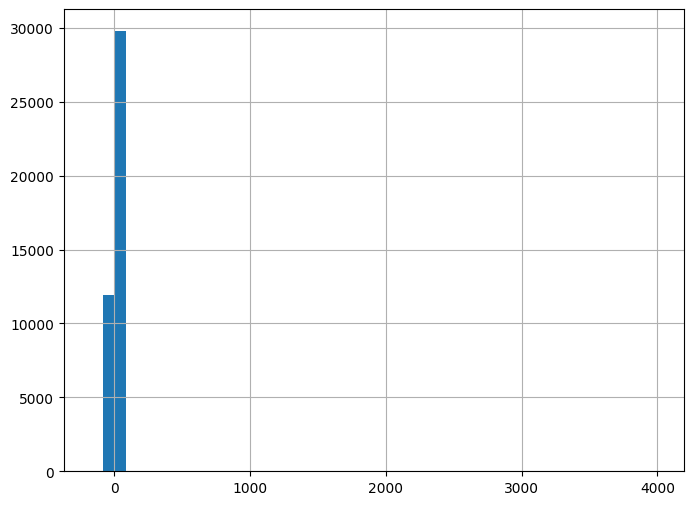

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [ ]:
diff_df.difference.describe()

,difference
count,41701.00
mean,4.47
std,26.05
min,-165.00
25%,0.00
50%,4.99
75%,6.99
max,3984.99


We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

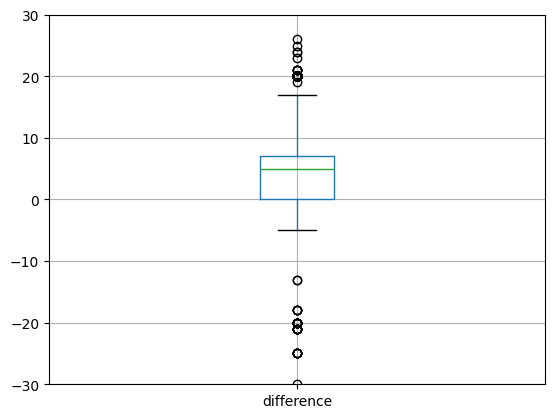

In [ ]:
# We know this rule from the boxplot
import matplotlib.pyplot as plt

ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

Q1, Q3

(0.0, 6.989999999999981)

In [ ]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

6.989999999999981

In [ ]:
# lower boundary
Q1 - 1.5*IQR

-10.484999999999971

In [ ]:
# upper boundary
Q3 + 1.5*IQR

17.47499999999995

In [ ]:
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[
    (diff_df["difference"] >= (Q1 - 1.5*IQR))
    &
    (diff_df["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

Let's look at the distribution again to see the effect of removing the outliers.

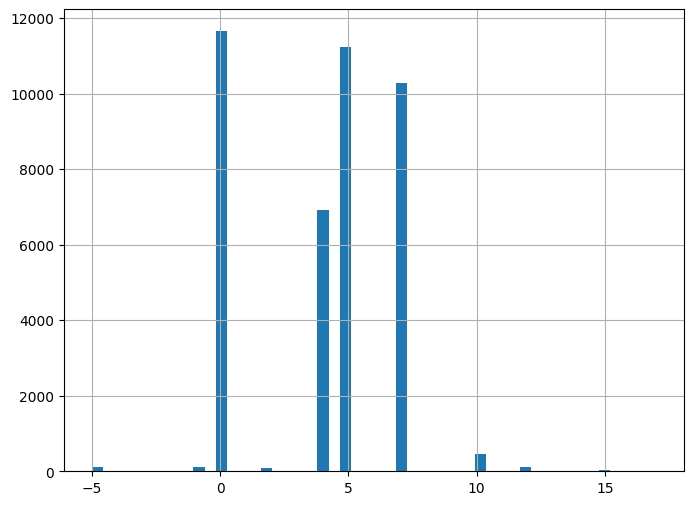

In [ ]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

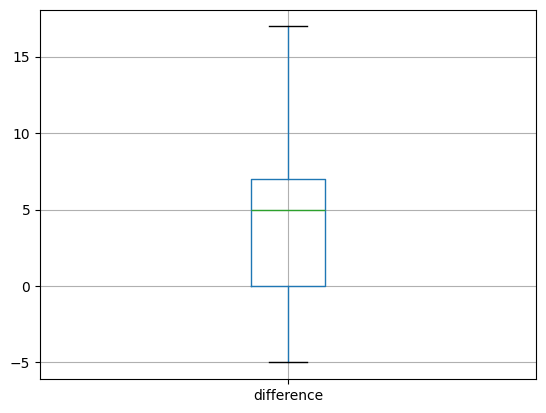

In [ ]:
diff_no_outliers_df.boxplot("difference")

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [ ]:
normal_diff_list = diff_no_outliers_df["order_id"]

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(normal_diff_list), :]

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(40985, 40985)

## 5.&nbsp; Become confident about dataset

In [ ]:
orderlines_qu.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50


## create a merged table and inspect discounts

In [ ]:
orderlines_qu = orderlines_qu.rename(columns = {"id_order":"order_id"})

In [ ]:
merged_orders = orders_qu.merge(orderlines_qu, on = "order_id").merge(products_cl, how ="left", on ="sku")

In [ ]:
#we don't need all the columns
merged_orders_short = merged_orders.drop(columns= ["id","state","product_id","name","desc","in_stock","type"]).copy()

In [ ]:
merged_orders_short

,order_id,created_date,total_paid,product_quantity,sku,unit_price,date,price
0,241423,2017-11-06 13:10:02,136.15,1,LAC0212,129.16,2017-11-06 12:47:20,139.99
1,242832,2017-12-31 17:40:03,15.76,1,PAR0074,10.77,2017-12-31 17:26:40,17.99
2,243330,2017-02-16 10:59:38,84.98,1,OWC0074,77.99,2017-02-15 17:07:44,99.99
3,245275,2017-06-28 11:35:37,149.00,1,TAD0007,149.00,2017-06-28 11:12:30,179.00
4,245595,2017-01-21 12:52:47,112.97,2,PAC1561,52.99,2017-01-21 12:49:00,103.95
...,...,...,...,...,...,...,...,...
53226,527042,2018-03-14 11:47:50,18.98,1,APP0927,13.99,2018-03-14 11:42:38,35.00
53227,527070,2018-03-14 11:50:48,24.97,2,APP0698,9.99,2018-03-14 11:49:01,25.00
53228,527074,2018-03-14 11:51:42,24.97,2,APP0698,9.99,2018-03-14 11:49:36,25.00
53229,527096,2018-03-14 11:58:40,34.96,3,APP0698,9.99,2018-03-14 11:54:35,25.00


In [ ]:
merged_orders_short["item_price_total"] = merged_orders_short["unit_price"]* merged_orders_short['product_quantity']

In [ ]:
merged_orders_short["discount"] = merged_orders_short['price']- merged_orders_short["unit_price"]

In [ ]:
merged_orders_short.sample(10)

,order_id,created_date,total_paid,product_quantity,sku,unit_price,date,price,item_price_total,discount
4432,313488,2017-01-22 23:45:38,39.99,1,BEL0300,39.99,2017-01-22 23:44:04,39.99,39.99,0.00
12250,357246,2017-05-19 10:28:09,663.98,1,SEA0044,93.99,2017-05-19 10:17:15,112.00,93.99,18.01
3162,309769,2017-01-16 01:11:20,384.97,2,CRU0052,188.99,2017-01-15 15:09:42,260.90,377.98,71.91
39615,468619,2017-12-23 12:19:37,393.98,1,APP2504,389.99,2017-12-23 12:16:55,399.00,389.99,9.01
26959,418081,2017-10-26 13:42:32,373.98,1,LGE0069,369.99,2017-10-26 13:37:12,399.00,369.99,29.01
5924,317861,2017-01-30 23:13:57,264.09,1,LAC0205,260.10,2017-01-30 22:58:36,259.00,260.10,-1.10
35362,448959,2017-11-27 18:06:12,60.30,1,WAC0171,56.31,2017-11-27 17:59:26,79.99,56.31,23.68
35347,448936,2017-11-27 17:59:05,143.53,1,CRU0026-2,138.54,2017-11-27 17:48:10,163.98,138.54,25.44
33244,441707,2017-11-25 09:02:13,120.34,1,LAC0212,116.35,2017-11-25 07:55:33,139.99,116.35,23.64
39331,467642,2017-12-20 10:32:34,42.99,1,SAT0029,42.99,2017-12-20 10:47:11,54.99,42.99,12.00


In [ ]:
merged_orders_short["discount"].describe()

,discount
count,53231.00
mean,26.12
std,45.55
min,-170.99
25%,5.25
50%,15.00
75%,31.00
max,1320.00


In [ ]:
merged_orders_short["discount_perc"]= round((merged_orders_short["discount"]/merged_orders_short["price"])*100,2)

In [ ]:
merged_orders_short["discount_perc"].describe()

,discount_perc
count,53231.00
mean,21.38
std,18.15
min,-212.27
25%,9.09
50%,17.65
75%,28.59
max,97.14


inspect the negative discount values

In [ ]:
minus_discounts = merged_orders_short.loc[merged_orders_short.discount_perc < 0,].sort_values(by = "discount_perc")

In [ ]:
# You could group the discounts to see how many values are there, but this results in a huge amount of categories
minus_discounts.groupby("discount_perc")["order_id"].count().sort_values(ascending = False)

,order_id
discount_perc,
-0.10,122
-0.16,114
-0.04,92
-0.20,90
-0.27,66
-0.11,38
-0.07,34
-20.34,30
-0.08,28


In [ ]:
# we could create a second column where you create groups for the discounts to have a clearer viw
minus_discounts["interval"] = ""
minus_discounts.loc[minus_discounts.discount_perc > -1, "interval" ] = "below 1"